<a href="https://colab.research.google.com/github/HRJ369/CL249--Computational-Lab/blob/main/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged in 3542 iterations.


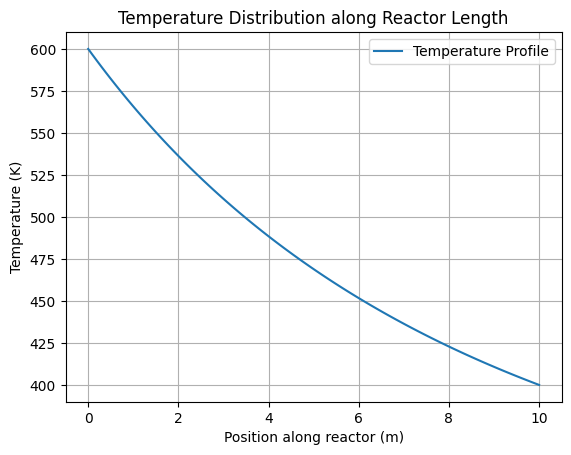

Temperature at x = 7 m: 437.41 K


In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
L = 10  # length of the reactor (m)
Q = 2e5  # heat generation term (W/m^3)
k = 50  # thermal conductivity (W/m·K)
Ta = 298  # ambient temperature (K)
T0 = 600  # Temperature at x=0 (K)
TL = 400  # Temperature at x=L (K)
N = 100  # number of discretization points
dx = L / (N + 1)  # spatial step size

# Temperature scaling factor to avoid overflow
T_ref = T0  # reference temperature for scaling (initial temperature at inlet)
Ta_scaled = Ta / T_ref
Ta_cubed_scaled = Ta_scaled ** 3  # scaled Ta^3

# Initialize scaled temperature array
T = np.linspace(T0, TL, N + 2) / T_ref  # scale initial guess

# Tolerance and maximum iterations for iterative method
tolerance = 1e-6
max_iter = 10000

def solve_temperature():
    for iteration in range(max_iter):
        T_old = T.copy()  # store the old temperature values
        max_diff = 0  # track maximum difference for convergence

        # Update temperatures at interior points (using Gauss-Seidel approach)
        for i in range(1, N + 1):
            # Finite difference approximation for second derivative
            d2T_dx2 = (T[i+1] - 2*T[i] + T[i-1]) / dx**2

            # Nonlinear term (T^3 - Ta^3) in scaled units
            nonlinear_term = Q / (k * T_ref**2) * (T[i]**3 - Ta_cubed_scaled)

            # Update temperature using finite difference equation
            T[i] = (T[i+1] + T[i-1] - nonlinear_term * dx**2) / 2

            # Track maximum difference for convergence check
            max_diff = max(max_diff, abs(T[i] - T_old[i]))

        # Check for convergence
        if max_diff < tolerance:
            print(f"Converged in {iteration} iterations.")
            break
    else:
        print("Warning: Did not converge within the maximum number of iterations.")

    return T

# Solve for temperature distribution in scaled units
T_solution_scaled = solve_temperature()

# Convert the solution back to original temperature scale
T_solution = T_solution_scaled * T_ref

# Plot the temperature distribution
x = np.linspace(0, L, N + 2)  # x values from 0 to L
plt.plot(x, T_solution, label='Temperature Profile')
plt.xlabel('Position along reactor (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution along Reactor Length')
plt.grid(True)
plt.legend()
plt.show()

# Find temperature at x = 7 m
x_target = 7
idx = int(x_target / dx)
T_at_7m = T_solution[idx]
print(f"Temperature at x = {x_target} m: {T_at_7m:.2f} K")


Concentration at r = 0.5 m is: 0.1006 mol/m^3


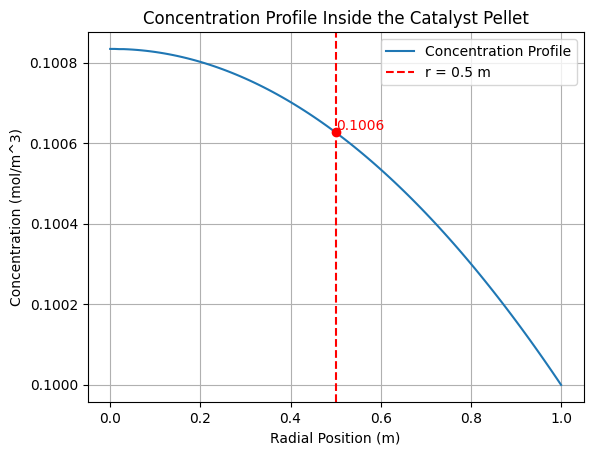

In [40]:
import matplotlib.pyplot as plt

# Parameters
r0 = 0.0  # Center of the pellet (m)
r1 = 1.0  # Surface of the pellet (m)
C_s = 0.1  # Concentration at the surface (mol/m^3)
k = 0.5    # Reaction rate constant (mol/m^3/s)
n = 2      # Reaction order
num_points = 100  # Number of discretized points
h = (r1 - r0) / num_points  # Step size for radial discretization

# Define the differential equation manually (Euler's method)
def euler_step(r, C, dCdr, h):
    """Performs one Euler step for both C and dC/dr."""
    if r == 0:
        d2Cdr2 = -k * C**n  # Symmetry at r = 0 (remove singularity)
    else:
        d2Cdr2 = -(2/r) * dCdr - k * C**n
    C_new = C + h * dCdr
    dCdr_new = dCdr + h * d2Cdr2
    return C_new, dCdr_new

# Boundary conditions for the shooting method
def boundary_condition(C0_guess):
    r = r0
    C = C0_guess
    dCdr = 0  # Symmetry condition at r0 (center)

    # Manually solve the ODE using Euler's method
    for i in range(num_points):
        C, dCdr = euler_step(r, C, dCdr, h)
        r += h

    # Return the difference between C at r1 and the known boundary condition C_s
    return C - C_s

# Manual bisection method for root finding (shooting method)
def shooting_method():
    tol = 1e-6
    lower_bound = 0
    upper_bound = 1
    C0_guess = (lower_bound + upper_bound) / 2

    while abs(boundary_condition(C0_guess)) > tol:
        if boundary_condition(C0_guess) > 0:
            upper_bound = C0_guess
        else:
            lower_bound = C0_guess
        C0_guess = (lower_bound + upper_bound) / 2

    return C0_guess

# Get the correct initial concentration at r = 0 using the shooting method
C0 = shooting_method()

# Solve the ODE using Euler's method with the correct initial condition
r_values = [r0 + i * h for i in range(num_points + 1)]  # Discretize radial positions manually
C_values = [C0]  # Initial concentration at r0
dCdr_values = [0]  # Initial derivative at r0 (symmetry)

# Perform Euler integration to calculate concentration profile
for i in range(1, num_points + 1):
    r = r_values[i]
    C_new, dCdr_new = euler_step(r_values[i-1], C_values[-1], dCdr_values[-1], h)
    C_values.append(C_new)
    dCdr_values.append(dCdr_new)

# Manual interpolation to find the concentration at r = 0.5 m
def manual_interpolation(r_values, C_values, r_target):
    for i in range(len(r_values) - 1):
        if r_values[i] <= r_target <= r_values[i + 1]:
            slope = (C_values[i + 1] - C_values[i]) / (r_values[i + 1] - r_values[i])
            return C_values[i] + slope * (r_target - r_values[i])
    return None  # In case r_target is out of bounds

# Determine the concentration at r = 0.5 m
r_target = 0.5
C_at_r_target = manual_interpolation(r_values, C_values, r_target)

print(f"Concentration at r = {r_target} m is: {C_at_r_target:.4f} mol/m^3")

# Plot the concentration profile
plt.plot(r_values, C_values, label="Concentration Profile")
plt.xlabel('Radial Position (m)')
plt.ylabel('Concentration (mol/m^3)')
plt.title('Concentration Profile Inside the Catalyst Pellet')

# Plot the vertical red line at r = 0.5
plt.axvline(x=r_target, color='red', linestyle='--', label=f'r = {r_target} m')

# Mark the point at r = 0.5 with a red dot
plt.scatter(r_target, C_at_r_target, color='red', zorder=5)

# Annotate the point with the concentration value
plt.text(r_target, C_at_r_target, f'{C_at_r_target:.4f}', color='red', fontsize=10, verticalalignment='bottom')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()
